In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertModel, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [2]:
df_01 = pd.read_csv("/kaggle/input/depression-reddit-cleaned/depression_dataset_reddit_cleaned.csv")
df_02 = pd.read_csv("/kaggle/input/mental-health-corpus/mental_health.csv")

In [3]:
def clean_text(text):
    pattern = r'\s?(https?://\S+|www\.\S+|[@#]\w+|\b\w{1,2}\b)'
    return re.sub(pattern, '', text).strip().lower()

s_01 = [clean_text(i) for i in df_01["clean_text"]]
s_02 = [clean_text(i) for i in df_02["text"]]

In [4]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenized_01 = tokenizer(s_01, padding=True, truncation=True, max_length=128, return_tensors="pt")
tokenized_02 = tokenizer(s_02, padding=True, truncation=True, max_length=128, return_tensors="pt")

labels_01 = torch.tensor(df_01["is_depression"].values, dtype=torch.long)
labels_02 = torch.tensor(df_02["label"].values, dtype=torch.long)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
input_ids = torch.cat((tokenized_01["input_ids"], tokenized_02["input_ids"]))
attention_masks = torch.cat((tokenized_01["attention_mask"], tokenized_02["attention_mask"]))
labels = torch.cat((labels_01, labels_02))

In [6]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)

In [7]:
class DepressionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx]
        }

In [8]:
train_dataset = DepressionDataset(train_inputs, train_masks, train_labels)
test_dataset = DepressionDataset(test_inputs, test_masks, test_labels)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return attn_output

In [11]:
class BertCNNClassifier(nn.Module):
    def __init__(self):
        super(BertCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.attention = MultiHeadSelfAttention(embed_dim=128, num_heads=4)
        self.layer_norm = nn.LayerNorm(128)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 2)
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_output.last_hidden_state.permute(0, 2, 1)
        conv_out = torch.relu(self.conv1(embeddings))
        conv_out = torch.relu(self.conv2(conv_out))
        conv_out = conv_out.permute(0, 2, 1)
        attn_out = self.attention(conv_out)
        attn_out = self.layer_norm(attn_out)
        pooled = torch.max(attn_out, dim=1).values
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertCNNClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=10 * len(train_loader))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
train_losses = []
train_accuracies = []
epochs = 10

In [14]:
model.train()
for epoch in range(epochs):
    total_loss = 0
    correct, total = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(correct / total)

    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}, Accuracy: {train_accuracies[-1]:.4f}")

Epoch 1/10: 100%|██████████| 893/893 [05:25<00:00,  2.74it/s, loss=0.0209]


Epoch 1 completed. Avg Loss: 0.1692, Accuracy: 0.9354


Epoch 2/10: 100%|██████████| 893/893 [05:26<00:00,  2.73it/s, loss=0.2088]


Epoch 2 completed. Avg Loss: 0.0756, Accuracy: 0.9742


Epoch 3/10: 100%|██████████| 893/893 [05:26<00:00,  2.73it/s, loss=0.0473]


Epoch 3 completed. Avg Loss: 0.0377, Accuracy: 0.9881


Epoch 4/10: 100%|██████████| 893/893 [05:26<00:00,  2.73it/s, loss=0.0026]


Epoch 4 completed. Avg Loss: 0.0205, Accuracy: 0.9936


Epoch 5/10: 100%|██████████| 893/893 [05:26<00:00,  2.73it/s, loss=0.0005]


Epoch 5 completed. Avg Loss: 0.0112, Accuracy: 0.9968


Epoch 6/10: 100%|██████████| 893/893 [05:27<00:00,  2.73it/s, loss=0.0020]


Epoch 6 completed. Avg Loss: 0.0067, Accuracy: 0.9982


Epoch 10/10: 100%|██████████| 893/893 [05:27<00:00,  2.73it/s, loss=0.0002]

Epoch 10 completed. Avg Loss: 0.0015, Accuracy: 0.9997


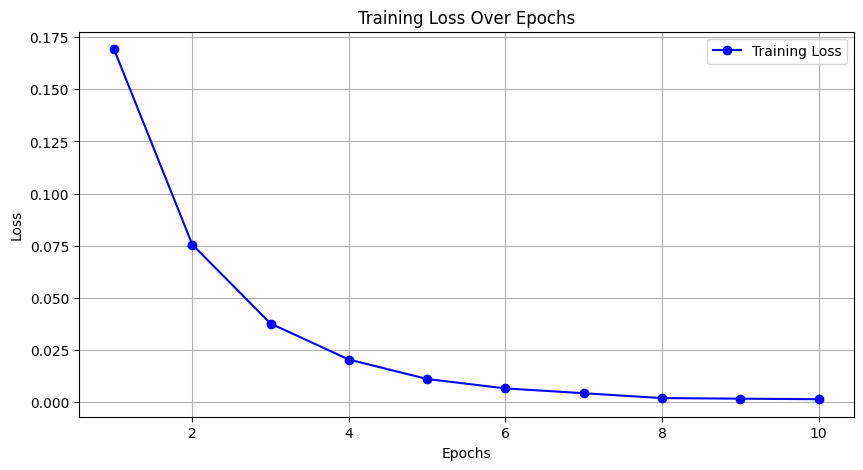

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.legend()
plt.show()


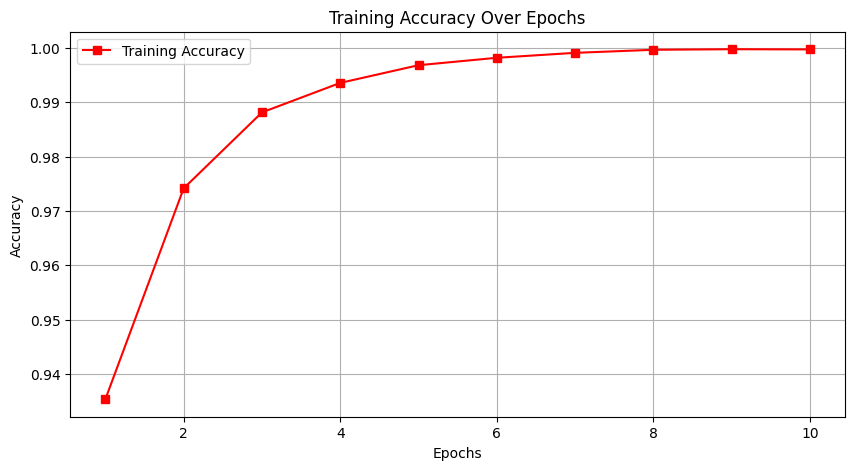

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, marker='s', linestyle='-', color='r', label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")
plt.grid()
plt.legend()
plt.show()


In [17]:
"""model.eval()
all_preds = []
all_labels = []
progress_bar = tqdm(test_loader, desc="Evaluating")

with torch.no_grad():
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")"""

'model.eval()\nall_preds = []\nall_labels = []\nprogress_bar = tqdm(test_loader, desc="Evaluating")\n\nwith torch.no_grad():\n    for batch in progress_bar:\n        input_ids = batch["input_ids"].to(device)\n        attention_mask = batch["attention_mask"].to(device)\n        labels = batch["labels"].to(device)\n        \n        outputs = model(input_ids, attention_mask)\n        preds = torch.argmax(outputs, dim=1)\n        \n        all_preds.extend(preds.cpu().numpy())\n        all_labels.extend(labels.cpu().numpy())\n\naccuracy = accuracy_score(all_labels, all_preds)\nprint(f"Test Accuracy: {accuracy:.4f}")'

Evaluating: 100%|██████████| 224/224 [00:24<00:00,  9.24it/s]


Test Accuracy: 0.9623


<Figure size 1000x800 with 0 Axes>

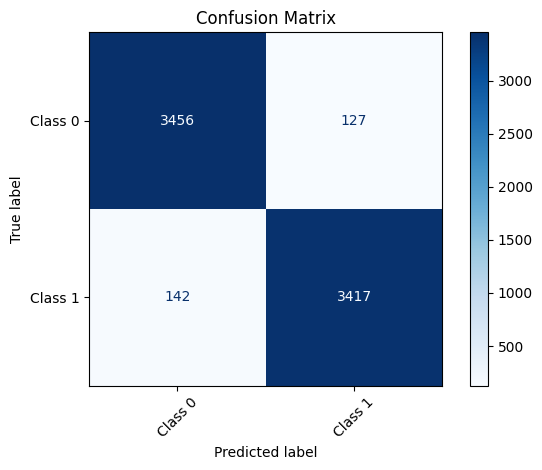


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96      3583
     Class 1       0.96      0.96      0.96      3559

    accuracy                           0.96      7142
   macro avg       0.96      0.96      0.96      7142
weighted avg       0.96      0.96      0.96      7142



In [18]:
model.eval()
all_preds = []
all_labels = []
progress_bar = tqdm(test_loader, desc="Evaluating")
with torch.no_grad():
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
num_classes = len(set(all_labels))
class_names = [f"Class {i}" for i in range(num_classes)]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# EEG

In [19]:
import pandas as pd

In [20]:
df = pd.read_csv("/kaggle/input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv")

In [21]:
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [22]:
df["specific.disorder"].unique()

array(['Alcohol use disorder', 'Acute stress disorder',
       'Depressive disorder', 'Healthy control',
       'Behavioral addiction disorder', 'Obsessive compulsitve disorder',
       'Schizophrenia', 'Panic disorder', 'Social anxiety disorder',
       'Posttraumatic stress disorder', 'Adjustment disorder',
       'Bipolar disorder'], dtype=object)

In [23]:
count = df[df["specific.disorder"] == "Depressive disorder"].shape[0]

In [24]:
count

199

In [25]:
df.describe()

,no.,age,education,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
count,945.000000,945.000000,930.000000,932.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,...,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000,945.000000
mean,473.000000,30.594804,13.438710,101.580472,20.182936,21.177584,17.749553,18.901698,20.447079,19.490329,...,75.889633,55.049113,56.959796,60.739169,69.829254,47.862489,66.832798,39.301406,66.153213,57.056207
std,272.942302,11.781592,2.550461,17.022414,11.282022,12.230662,10.003598,9.079482,9.742912,9.252500,...,15.861641,19.541956,18.326785,18.052887,17.725321,19.685722,17.028701,20.790933,18.088548,19.600107
min,1.000000,18.000000,0.000000,49.000000,3.272260,3.244199,3.050507,3.412618,5.066593,4.048931,...,12.611954,0.519048,6.926792,0.708008,2.421748,0.036664,1.032207,1.228502,0.363268,3.988805
25%,237.000000,21.730000,12.000000,91.000000,12.784872,13.019269,11.134327,12.460586,13.548645,12.637717,...,68.014443,41.607506,43.682444,48.374883,58.937785,32.581046,55.872070,22.049743,54.710605,43.955229
50%,473.000000,26.150000,13.000000,102.000000,17.065286,17.838251,15.541469,16.733004,18.065276,17.432568,...,78.647712,55.158858,56.657348,61.257972,72.298636,45.719426,68.238375,36.549938,67.988937,57.515871
75%,709.000000,35.450000,16.000000,114.000000,24.492760,25.654394,21.623961,23.347900,25.573096,23.956748,...,87.398387,69.740640,70.649245,73.979100,83.066877,62.081839,79.192418,54.169209,79.527764,71.626382
max,945.000000,71.880000,20.000000,145.000000,92.826192,101.515687,91.373456,82.544167,101.566662,77.197502,...,99.678649,100.000000,99.307895,100.000000,99.581629,98.720067,99.650154,98.413320,100.000000,99.287092


In [26]:
df.isna().sum()

no.                       0
sex                       0
age                       0
eeg.date                  0
education                15
                         ..
COH.F.gamma.p.P4.r.O1     0
COH.F.gamma.p.P4.s.O2     0
COH.F.gamma.q.T6.r.O1     0
COH.F.gamma.q.T6.s.O2     0
COH.F.gamma.r.O1.s.O2     0
Length: 1149, dtype: int64

In [27]:
df = df.drop(columns=["eeg.date", "education", "no.", "main.disorder"])

In [28]:
df["is_depressive_disorder"] = (df["specific.disorder"] == "Depressive disorder").astype(int)

In [29]:
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,is_depressive_disorder
0,M,57.0,NaN,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,...,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,0
1,M,37.0,120.0,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,0
2,M,32.0,113.0,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,0
3,M,35.0,126.0,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,0
4,M,36.0,112.0,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,M,22.0,116.0,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,...,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230,0
941,M,26.0,118.0,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,...,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868,0
942,M,26.0,113.0,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,...,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111,0
943,M,24.0,107.0,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,...,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446,0


In [30]:
df["sex_numeric"] = df["sex"].map({"M": 1, "F": 0})

In [31]:
iq_avg = df["IQ"].mean()
df["IQ"] = df["IQ"].fillna(iq_avg)

In [32]:
df

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,is_depressive_disorder,sex_numeric
0,M,57.0,101.580472,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,...,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,0,1
1,M,37.0,120.000000,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,...,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,0,1
2,M,32.0,113.000000,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,...,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,0,1
3,M,35.0,126.000000,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,...,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,0,1
4,M,36.0,112.000000,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,...,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,M,22.0,116.000000,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,...,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230,0,1
941,M,26.0,118.000000,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,...,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868,0,1
942,M,26.0,113.000000,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,...,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111,0,1
943,M,24.0,107.000000,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,...,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446,0,1


In [33]:
df = df.drop(columns=["sex_numeric"])

In [34]:
df["sex"] = df["sex"].map({"M": 1, "F": 0})

In [35]:
df

,sex,age,IQ,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,is_depressive_disorder
0,1,57.0,101.580472,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,...,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,0
1,1,37.0,120.000000,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,0
2,1,32.0,113.000000,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,0
3,1,35.0,126.000000,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,0
4,1,36.0,112.000000,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1,22.0,116.000000,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,...,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230,0
941,1,26.0,118.000000,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,...,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868,0
942,1,26.0,113.000000,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,...,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111,0
943,1,24.0,107.000000,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,...,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446,0


In [36]:
df = df.drop(columns=["specific.disorder"])

In [37]:
df

,sex,age,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,is_depressive_disorder
0,1,57.0,101.580472,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,...,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,0
1,1,37.0,120.000000,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,0
2,1,32.0,113.000000,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,0
3,1,35.0,126.000000,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,0
4,1,36.0,112.000000,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1,22.0,116.000000,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,...,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230,0
941,1,26.0,118.000000,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,...,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868,0
942,1,26.0,113.000000,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,...,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111,0
943,1,24.0,107.000000,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,...,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446,0


In [38]:
nan_count = df.isna().sum()

for column, count in nan_count.items():
    if count!=0:
        print(f"Column '{column}' has {count} NaN values.")

Column 'Unnamed: 122' has 945 NaN values.


In [39]:
df = df.drop(columns=["Unnamed: 122"])

In [40]:
df

,sex,age,IQ,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,...,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2,is_depressive_disorder
0,1,57.0,101.580472,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,...,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029,0
1,1,37.0,120.000000,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,...,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261,0
2,1,32.0,113.000000,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,...,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799,0
3,1,35.0,126.000000,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,...,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873,0
4,1,36.0,112.000000,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,...,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1,22.0,116.000000,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,...,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230,0
941,1,26.0,118.000000,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,...,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868,0
942,1,26.0,113.000000,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,...,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111,0
943,1,24.0,107.000000,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,...,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446,0


In [41]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim


X = df.drop(columns=["is_depressive_disorder"])
y = df["is_depressive_disorder"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y)
pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [42]:

class DepressionPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(DepressionPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x


Epoch [1/30], Loss: 1.0955
Epoch [2/30], Loss: 1.0837
Epoch [3/30], Loss: 1.0673
Epoch [4/30], Loss: 1.0429
Epoch [5/30], Loss: 1.0109
Epoch [6/30], Loss: 0.9689
Epoch [7/30], Loss: 0.9201
Epoch [8/30], Loss: 0.8655
Epoch [9/30], Loss: 0.8018
Epoch [10/30], Loss: 0.7258
Epoch [11/30], Loss: 0.6397
Epoch [12/30], Loss: 0.5707
Epoch [13/30], Loss: 0.5448
Epoch [14/30], Loss: 0.4964
Epoch [15/30], Loss: 0.4713
Epoch [16/30], Loss: 0.3559
Epoch [17/30], Loss: 0.4064
Epoch [18/30], Loss: 0.2612
Epoch [19/30], Loss: 0.3211
Epoch [20/30], Loss: 0.1951
Epoch [21/30], Loss: 0.2306
Epoch [22/30], Loss: 0.1731
Epoch [23/30], Loss: 0.1267
Epoch [24/30], Loss: 0.1437
Epoch [25/30], Loss: 0.0876
Epoch [26/30], Loss: 0.0824
Epoch [27/30], Loss: 0.0712
Epoch [28/30], Loss: 0.0423
Epoch [29/30], Loss: 0.0520
Epoch [30/30], Loss: 0.0367
Test Accuracy: 0.7143


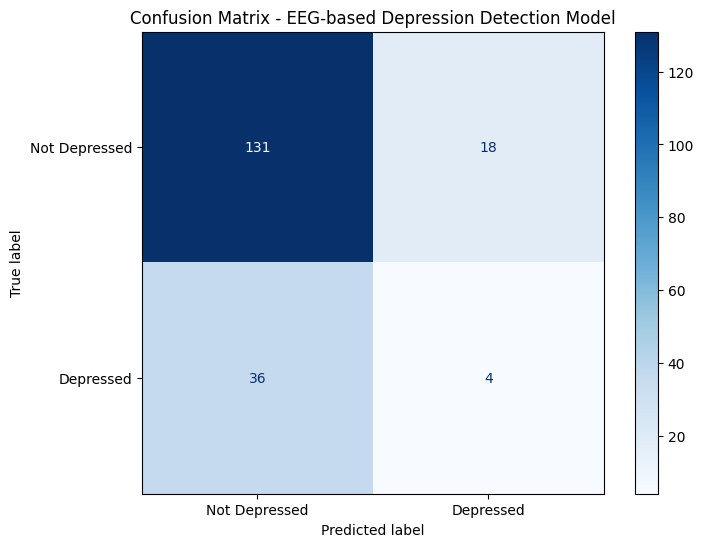

Confusion Matrix:
[[131  18]
 [ 36   4]]
Sensitivity/Recall: 0.1000
Specificity: 0.8792
Precision: 0.1818
F1 Score: 0.1290


In [65]:
input_size = X_train.shape[1]
model1 = DepressionPredictionModel(input_size=input_size)
optimizer = optim.Adam(model1.parameters(), lr=0.001)

num_epochs =30
for epoch in range(num_epochs):
    model1.train()
    outputs = model1(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model1.eval()
with torch.no_grad():
    test_outputs = model1(X_test_tensor)
    test_predictions = torch.sigmoid(test_outputs)
    test_predictions = (test_predictions > 0.5).float()
    
    accuracy = (test_predictions == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")
    
    y_true = y_test_tensor.cpu().numpy().flatten()
    y_pred = test_predictions.cpu().numpy().flatten()
    
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Depressed', 'Depressed'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix - EEG-based Depression Detection Model')
    plt.show()
    
    print("Confusion Matrix:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0 
    
    print(f"Sensitivity/Recall: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")

# 3) soft polling and hard polling tests for both the models

# With normalization

In [66]:
import torch
import torch.nn.functional as F
import numpy as np
import math

def get_bert_probabilities(model, dataloader, device):
    """
    Get probabilities from the BERT model using softmax.
    """
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    """
    Get probabilities from the EEG model using sigmoid activation.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs


bert_probs = get_bert_probabilities(model, test_loader, device)
eeg_probs_raw = get_eeg_probabilities(model1, X_test_tensor)

eeg_probs_raw = (eeg_probs_raw - eeg_probs_raw.min()) / (eeg_probs_raw.max() - eeg_probs_raw.min())

repeat_factor = math.ceil(len(bert_probs) / len(eeg_probs_raw))  # ≈ 7142 / 189
eeg_probs_repeated = eeg_probs_raw.repeat_interleave(repeat_factor)[:len(bert_probs)]

final_probs = (bert_probs + eeg_probs_repeated) / 2
final_predictions = (final_probs > 0.5).float()

duplicated_labels = torch.tensor(np.tile(y_test.values, repeat_factor)[:len(bert_probs)], dtype=torch.float32)

final_accuracy = (final_predictions == duplicated_labels).float().mean().item()
print(f"Soft Voting Test Accuracy(with EEG duplication): {final_accuracy:.4f}")


Soft Voting Test Accuracy(with EEG duplication): 0.6026


In [67]:
import torch
import torch.nn.functional as F
import numpy as np
import random

def get_bert_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs


bert_probs_full = get_bert_probabilities(model, test_loader, device)
eeg_probs = get_eeg_probabilities(model1, X_test_tensor)

eeg_probs = (eeg_probs - eeg_probs.min()) / (eeg_probs.max() - eeg_probs.min())

selected_indices = torch.tensor(random.sample(range(len(bert_probs_full)), len(eeg_probs)))
bert_probs_sampled = bert_probs_full[selected_indices]

final_probs = (bert_probs_sampled + eeg_probs) / 2
final_predictions = (final_probs > 0.5).float()

duplicated_labels = torch.tensor(y_test.values, dtype=torch.float32)
final_accuracy = (final_predictions == duplicated_labels).float().mean().item()

print(f"Soft Voting Test Accuracy (Random Sampled BERT): {final_accuracy:.4f}")


Soft Voting Test Accuracy (Random Sampled BERT): 0.6296


In [68]:
import torch
import torch.nn.functional as F
import numpy as np
import random

def get_bert_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs

bert_probs_full = get_bert_probabilities(model, test_loader, device)
eeg_probs = get_eeg_probabilities(model1, X_test_tensor)

eeg_probs = (eeg_probs - eeg_probs.min()) / (eeg_probs.max() - eeg_probs.min())

random_indices = torch.tensor(random.sample(range(len(bert_probs_full)), len(eeg_probs)))
bert_probs_sampled = bert_probs_full[random_indices]

bert_preds = (bert_probs_sampled > 0.5).long()
eeg_preds = (eeg_probs > 0.5).long()

final_preds = ((bert_preds + eeg_preds) > 1).long()

true_labels = torch.tensor(y_test.values, dtype=torch.long)
final_accuracy = (final_preds == true_labels).float().mean().item()

print(f"Hard Voting Test Accuracy(Random Sampled BERT): {final_accuracy:.4f}")


Hard Voting Test Accuracy(Random Sampled BERT): 0.7354


In [69]:
import torch
import torch.nn.functional as F
import numpy as np
import math

def get_bert_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs

bert_probs = get_bert_probabilities(model, test_loader, device)
eeg_probs = get_eeg_probabilities(model1, X_test_tensor)

eeg_probs = (eeg_probs - eeg_probs.min()) / (eeg_probs.max() - eeg_probs.min())

repeat_factor = math.ceil(len(bert_probs) / len(eeg_probs))
eeg_probs_repeated = eeg_probs.repeat_interleave(repeat_factor)[:len(bert_probs)]

bert_preds = (bert_probs > 0.5).long()
eeg_preds = (eeg_probs_repeated > 0.5).long()

final_preds = ((bert_preds + eeg_preds) > 1).long()

true_labels = torch.tensor(np.tile(y_test.values, repeat_factor)[:len(bert_preds)], dtype=torch.long)

final_accuracy = (final_preds == true_labels).float().mean().item()
print(f"Hard Voting Test Accuracy (with EEG duplication): {final_accuracy:.4f}")


Hard Voting Test Accuracy (with EEG duplication): 0.7568


# Without Normalization

In [70]:
import torch
import torch.nn.functional as F
import numpy as np
import math

def get_bert_probabilities(model, dataloader, device):
    """
    Get probabilities from the BERT model using softmax.
    """
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    """
    Get probabilities from the EEG model using sigmoid activation.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs


bert_probs = get_bert_probabilities(model, test_loader, device)
eeg_probs_raw = get_eeg_probabilities(model1, X_test_tensor)


repeat_factor = math.ceil(len(bert_probs) / len(eeg_probs_raw))  # ≈ 7142 / 189
eeg_probs_repeated = eeg_probs_raw.repeat_interleave(repeat_factor)[:len(bert_probs)]

final_probs = (bert_probs + eeg_probs_repeated) / 2
final_predictions = (final_probs > 0.5).float()

duplicated_labels = torch.tensor(np.tile(y_test.values, repeat_factor)[:len(bert_probs)], dtype=torch.float32)

final_accuracy = (final_predictions == duplicated_labels).float().mean().item()
print(f"Soft Voting Test Accuracy(with EEG duplication): {final_accuracy:.4f}")


Soft Voting Test Accuracy(with EEG duplication): 0.6043


In [71]:
import torch
import torch.nn.functional as F
import numpy as np
import random

def get_bert_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs


bert_probs_full = get_bert_probabilities(model, test_loader, device)
eeg_probs = get_eeg_probabilities(model1, X_test_tensor)


selected_indices = torch.tensor(random.sample(range(len(bert_probs_full)), len(eeg_probs)))
bert_probs_sampled = bert_probs_full[selected_indices]

final_probs = (bert_probs_sampled + eeg_probs) / 2
final_predictions = (final_probs > 0.5).float()

duplicated_labels = torch.tensor(y_test.values, dtype=torch.float32)
final_accuracy = (final_predictions == duplicated_labels).float().mean().item()

print(f"Soft Voting Test Accuracy (Random Sampled BERT): {final_accuracy:.4f}")


Soft Voting Test Accuracy (Random Sampled BERT): 0.5873


In [72]:
import torch
import torch.nn.functional as F
import numpy as np
import math

def get_bert_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs

bert_probs = get_bert_probabilities(model, test_loader, device)
eeg_probs = get_eeg_probabilities(model1, X_test_tensor)


repeat_factor = math.ceil(len(bert_probs) / len(eeg_probs))
eeg_probs_repeated = eeg_probs.repeat_interleave(repeat_factor)[:len(bert_probs)]

bert_preds = (bert_probs > 0.5).long()
eeg_preds = (eeg_probs_repeated > 0.5).long()

final_preds = ((bert_preds + eeg_preds) > 1).long()

true_labels = torch.tensor(np.tile(y_test.values, repeat_factor)[:len(bert_preds)], dtype=torch.long)

final_accuracy = (final_preds == true_labels).float().mean().item()
print(f"Hard Voting Test Accuracy (with EEG duplication): {final_accuracy:.4f}")


Hard Voting Test Accuracy (with EEG duplication): 0.7568


# 

In [73]:
import torch
import torch.nn.functional as F
import numpy as np
import random

def get_bert_probabilities(model, dataloader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)
            probs_batch = F.softmax(outputs, dim=1)[:, 1]
            probabilities.extend(probs_batch.cpu().numpy())

    return torch.tensor(probabilities)

def get_eeg_probabilities(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).squeeze()

    return probs

bert_probs_full = get_bert_probabilities(model, test_loader, device)
eeg_probs = get_eeg_probabilities(model1, X_test_tensor)


random_indices = torch.tensor(random.sample(range(len(bert_probs_full)), len(eeg_probs)))
bert_probs_sampled = bert_probs_full[random_indices]

bert_preds = (bert_probs_sampled > 0.5).long()
eeg_preds = (eeg_probs > 0.5).long()

final_preds = ((bert_preds + eeg_preds) > 1).long()

true_labels = torch.tensor(y_test.values, dtype=torch.long)
final_accuracy = (final_preds == true_labels).float().mean().item()

print(f"Hard Voting Test Accuracy(Random Sampled BERT): {final_accuracy:.4f}")


Hard Voting Test Accuracy(Random Sampled BERT): 0.7725
